In [ ]:
!pip install selenium
!pip install transformers
!pip install sentencepiece
!pip install steamspypi

In [4]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import re
from openpyxl import Workbook
import csv
import requests
import os
from datetime import datetime
import time
import pandas as pd
from tqdm import tqdm
import json
import io
import glob

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from transformers import pipeline

import ast
import torch

import csv
import statistics
import numpy as np
import steamspypi

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 수집

## 게임명

In [ ]:
params = {
    'request': 'all',
    'format': 'json'
}

response = requests.get('https://api.steampowered.com/ISteamApps/GetAppList/v2/', params=params)

games = [game['name'] for game in response.json()['applist']['apps'] if game['name'].isascii()]

In [ ]:
games[:10]

['Grass Cut',
 'Adarin Farm Playtest',
 'Christmas Sort Puzzle - Expansion Pack',
 "Don't Starve Together: Merrymaker Survivors Chest, Part II",
 'HorrorDriven: A story for the road Demo',
 'Super Night Riders S1',
 'Slidetracked',
 'Red Bash',
 'EXIT 2 | Modding Tool',
 'Elemgate']

In [ ]:
len(games)

148548

## 게임명 -> app id

In [ ]:
# 8시간 소요

name_to_appid = {}

response = requests.get('https://api.steampowered.com/ISteamApps/GetAppList/v2/')

for i in tqdm(range(len(games))):
  game_name = games[i]
  apps = response.json()['applist']['apps']

  game = next((app for app in apps if app['name'] == game_name), None)

  if game:
    name_to_appid[game['name']] = game['appid']

In [ ]:
#게임명과 AppID 매칭
name_to_appid.to_csv("name_to_appid.csv", index = False)

#AppID 리스트
appid_list = list(name_to_appid.values())
pd.DataFrame(appid_list).to_csv("name_to_appid.csv", index = False)

In [ ]:
len(appid_list)

2505

## app id -> 댓글 개수

In [ ]:
appid_to_reviewcnt = []
for i in tqdm(range(len(appid_list))):
  params = {
      'json': 1,
      'filter': 'all',
      'language': 'all',
      'review_type': 'all',
      'day_range': '9223372036854775807'
  }

  appid = appid_list[i]
  try:
    response = requests.get(f'https://store.steampowered.com/appreviews/{appid}', params=params)

    num_reviews = response.json()['query_summary']['total_reviews']
    if num_reviews > 0:
      appid_to_reviewcnt.append([appid, num_reviews])
  except:
    pass
  #print(f'The game with app ID {appid} has {num_reviews} reviews.')

100%|██████████| 2505/2505 [07:31<00:00,  5.55it/s]


In [ ]:
appid_to_reviewcnt[:10]

[[1836600, 13],
 [1836680, 13],
 [1836690, 3],
 [1836740, 6],
 [1836770, 4],
 [1836780, 12],
 [1836790, 4],
 [1836860, 687],
 [1836880, 25],
 [1836900, 2]]

In [ ]:
len(appid_to_reviewcnt)

998

In [ ]:
pd.DataFrame(appid_to_reviewcnt).to_csv("appid_to_reviewcnt.csv", index = False)

## app id, 댓글 개수 -> 유저 리뷰 csv

In [ ]:
name_to_appid = pd.read_csv("/content/drive/MyDrive/DA-STEAM 게임시장분석/data/name_to_appid.csv")
appid_to_reviewcnt = pd.read_csv("/content/drive/MyDrive/DA-STEAM 게임시장분석/data/appid_to_reviewcnt.csv")

In [ ]:
name_to_appid = name_to_appid.values.tolist()
appid_to_reviewcnt = appid_to_reviewcnt.values.tolist()

In [ ]:
def get_reviews(appid, params):
        url_start = 'https://store.steampowered.com/appreviews/'
        try:
            response = requests.get(url=url_start+str(appid), params=params, headers={'User-Agent': 'Mozilla/5.0'})
        except:
                return {'reviews' : []}
        return response.json()

In [ ]:
def get_n_reviews(appid, n):
    reviews = []
    cursor = '*'
    params = {
            'json' : 1,
            'filter' : 'all',
            'language' : 'english', # 영어 리뷰만
            'day_range' : 9223372036854775807,
            'review_type' : 'all',
            'purchase_type' : 'all'
            }

    while n > 0:
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += response['reviews']

        if len(response['reviews']) < 100: break

    
    return reviews

In [ ]:
columns = ['recommendationid',
'language',
'review',
'timestamp_created',
'timestamp_updated',
'voted_up',
'votes_up',
'votes_funny',
'weighted_vote_score',
'comment_count',
'steam_purchase',
'received_for_free',
'written_during_early_access',
'hidden_in_steam_china',
'steam_china_location',
'author_steamid',
'author_num_games_owned',
'author_num_reviews',
'author_playtime_forever',
'author_playtime_last_two_weeks',
'author_playtime_at_review',
'author_last_played',
'timestamp_dev_responded',
'developer_response',
'appid']

In [ ]:
for i in tqdm(range(len(appid_to_reviewcnt))):
    try:
        appid = appid_to_reviewcnt[i][0]
        review_cnt = appid_to_reviewcnt[i][1]

        reviews = get_n_reviews(appid, review_cnt)

        reviews_df = pd.json_normalize(reviews, sep="_")

        # 정규표현식을 이용해 영어와 숫자로만 이루어진 문자열로 필터링
        reviews_df["review"] = reviews_df["review"].apply(lambda x: re.sub(r"[^a-zA-Z0-9.,?!~`@#$%^&*()_+-={}\[\]|\\;:'\"<>/ ]", "", x))

        # columns에 해당하는 열이 없으면 추가하기
        for col in columns:
            if col not in reviews_df.columns:
                reviews_df[col] = ""        
                
        reviews_df['timestamp_dev_responded'] = pd.to_numeric(reviews_df['timestamp_dev_responded'], errors='coerce')

        # unix timestamp를 시간으로 변환
        reviews_df['timestamp_created'] = reviews_df['timestamp_created'].apply(lambda t: datetime.utcfromtimestamp(t).strftime('%Y-%m-%d'))
        reviews_df['timestamp_updated'] = reviews_df['timestamp_updated'].apply(lambda t: datetime.utcfromtimestamp(t).strftime('%Y-%m-%d'))
        reviews_df['author_last_played'] = reviews_df['author_last_played'].apply(lambda t: datetime.utcfromtimestamp(t).strftime('%Y-%m-%d'))
        reviews_df['timestamp_dev_responded'] = reviews_df['timestamp_dev_responded'].apply(lambda t: datetime.utcfromtimestamp(t).strftime('%Y-%m-%d') if pd.notnull(t) else t)
        reviews_df['appid'] = appid
        
        reviews_df["developer_response"] = reviews_df["developer_response"].apply(lambda x: re.sub(r"[^a-zA-Z0-9.,?!~`@#$%^&*()_+-={}\[\]|\\;:'\"<>/ ]", "", str(x)))
        
        reviews_df.to_csv(f'C:/Users/sjkan/Desktop/연세/YBIGTA/23-상반기/23-1/steam/data2/{appid}.csv', index = False)
    except:
        pass

## 리뷰 합치기

In [ ]:
# CSV 파일들이 저장된 폴더 경로 설정
folder_path = "/content/drive/MyDrive/DA-STEAM 게임시장분석/data/review"

# 폴더 안의 모든 CSV 파일 경로를 리스트로 저장
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# 모든 CSV 파일의 열 이름 가져오기
columns = set()
for file in tqdm(csv_files):
    with open(file, 'r') as f:
        # 첫 번째 행만 읽어서 열 이름 가져오기
        first_line = f.readline()
        cols = pd.read_csv(io.StringIO(first_line)).columns
        columns = columns.union(cols)

# 합집합 출력하기
print(columns)

100%|██████████| 405/405 [00:08<00:00, 48.30it/s] 

{'author_playtime_forever', 'weighted_vote_score', 'author_playtime_at_review', 'written_during_early_access', 'received_for_free', 'review', 'author_playtime_last_two_weeks', 'hidden_in_steam_china', 'voted_up', 'developer_response', 'steam_purchase', 'timestamp_dev_responded', 'votes_up', 'steam_china_location', 'comment_count', 'author_num_games_owned', 'author_steamid', 'timestamp_updated', 'recommendationid', 'votes_funny', 'timestamp_created', 'author_last_played', 'appid', 'language', 'author_num_reviews'}


In [ ]:
# CSV 파일들이 저장된 폴더 경로 설정
folder_path = "/content/drive/MyDrive/DA-STEAM 게임시장분석/세정/review"

# 폴더 안의 모든 CSV 파일 경로를 리스트로 저장
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# 모든 CSV 파일을 읽어서 하나의 데이터프레임으로 합치기
df = pd.concat((pd.read_csv(f) for f in tqdm(csv_files)))

In [ ]:
df.columns

Index(['recommendationid', 'language', 'review', 'timestamp_created',
       'timestamp_updated', 'voted_up', 'votes_up', 'votes_funny',
       'weighted_vote_score', 'comment_count', 'steam_purchase',
       'received_for_free', 'written_during_early_access',
       'hidden_in_steam_china', 'steam_china_location', 'author_steamid',
       'author_num_games_owned', 'author_num_reviews',
       'author_playtime_forever', 'author_playtime_last_two_weeks',
       'author_playtime_at_review', 'author_last_played', 'appid',
       'timestamp_dev_responded', 'developer_response'],
      dtype='object')

## 장르

In [ ]:
genre_list = ['action', 'adventure', 'casual', 'racing', 'rpg', 'simulation', 'sports', 'strategy', 'free to play', 'easy access', 'indie', 'massively multiplayer']

data_frames = {}

for genre in tqdm(genre_list):
    data_request = {'request': 'genre', 'genre': genre}
    genre_data = steamspypi.download(data_request)
    genre_df = pd.DataFrame.from_dict(genre_data).transpose()
    genre_df['genre'] = genre
    data_frames[genre] = genre_df

100%|██████████| 12/12 [00:19<00:00,  1.62s/it]


In [ ]:
df_list = list(data_frames.values())
df_all = pd.concat(df_list, ignore_index=True)

# appid, name, genre 컬럼만 추출, appid 순으로 정렬 
df_genre = df_all[['appid', 'name', 'genre']].sort_values(by=['appid'])

# 게임 1개의 장르 1개당 1행: appid, name이 중복되는 행이 있음
# 게임 1개의 장르 n개를 1행에 합침
df_genre_v2 = df_genre.groupby(['appid', 'name'], as_index=False).agg(lambda x: ', '.join(set(x)))
df_genre_v2['genre_all'] = df_genre['genre']
df_genre_v2.drop('genre', axis=1, inplace=True)

df_genre_v2

,appid,name,genre_all
0,10,Counter-Strike,action
1,20,Team Fortress Classic,action
2,30,Day of Defeat,action
3,40,Deathmatch Classic,action
4,50,Half-Life: Opposing Force,action
...,...,...,...
62067,2423940,Broken Minds,casual
62068,2423960,Lord of the Click: Interstellar Wars,casual
62069,2425400,Birds Aren't Real,casual
62070,2425570,Roots Need Control 3.0,casual


In [ ]:
df_genre_v2.to_csv('/content/drive/MyDrive/YBIGTA/DA-STEAM 게임시장분석/은서/genre_data/df_genre_v2.csv', index = False)

# ABSA 감정분석 : Aspect-Based Sentiment Analysis

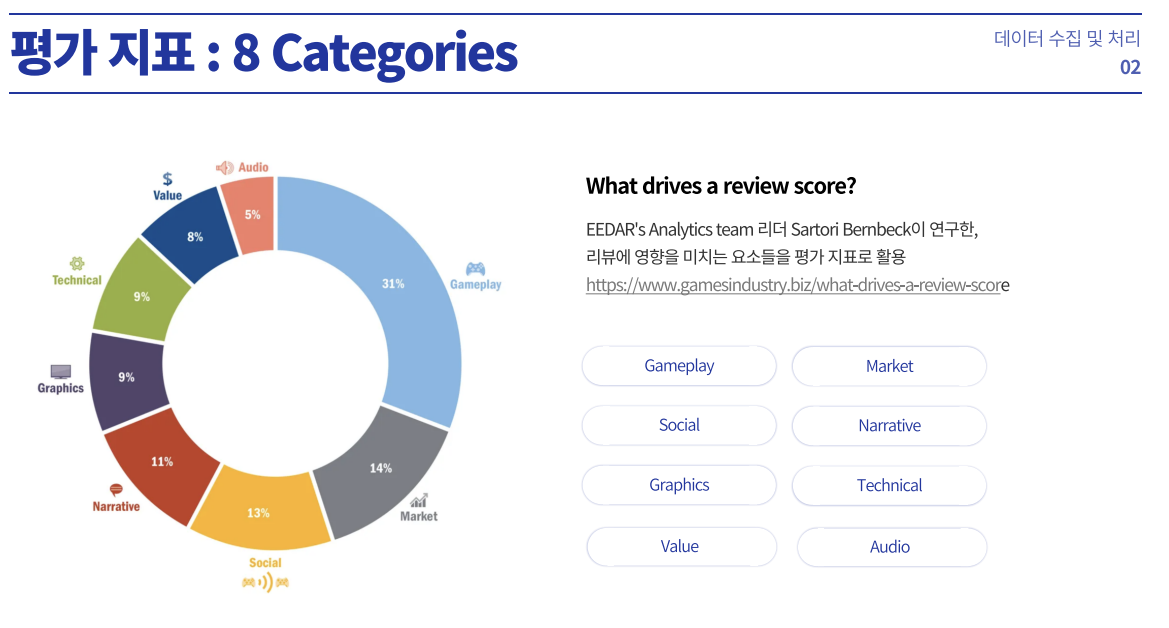

In [ ]:
tqdm.pandas()
df['review_category'] = df['review_category'].apply(ast.literal_eval)

aspects = ["gameplay", "market", "social", "narrative", "graphics", "technical", "value", "audio"]

for aspect in aspects:

    col_name_label = f"{aspect}_label"
    col_name_prob_negative = f"{aspect}_prob_negative"
    col_name_prob_neutral = f"{aspect}_prob_neutral"
    col_name_prob_positive = f"{aspect}_prob_positive"

    df[col_name_label] = None
    df[col_name_prob_negative] = None
    df[col_name_prob_neutral] = None
    df[col_name_prob_positive] = None

# ABSA 모델
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1").to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def process_aspect_sentiment(row):
  sentence = row['review']
  aspects = row['review_category']

  # Aspect별 감성분석 결과 저장
  label_cols = [f"{aspect}_label" for aspect in aspects]
  prob_negative_cols = [f"{aspect}_prob_negative" for aspect in aspects]
  prob_neutral_cols = [f"{aspect}_prob_neutral" for aspect in aspects]
  prob_positive_cols = [f"{aspect}_prob_positive" for aspect in aspects]

  for i, aspect in enumerate(aspects):
      with torch.no_grad():
        # ABSA 수행
        inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt").to(device)
        outputs = absa_model(**inputs)
        del inputs
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        del outputs
        probs = probs.detach().cpu().numpy()[0]

        row[label_cols[i]] = max(enumerate(probs), key=lambda x:x[1])[0]
        row[prob_negative_cols[i]] = probs[0]
        row[prob_neutral_cols[i]] = probs[1]
        row[prob_positive_cols[i]] = probs[2]
        
        del probs
        
  torch.cuda.empty_cache()
  return row

tqdm.pandas()
absa_data = df.progress_apply(process_aspect_sentiment, axis=1)

absa_data.to_csv('/content/drive/MyDrive/DA-STEAM 게임시장분석/세정/absa_data.csv', header=True, index=False)

In [4]:
absa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5341949 entries, 0 to 5341948
Data columns (total 60 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   recommendationid                int64  
 1   language                        object 
 2   review                          object 
 3   timestamp_created               object 
 4   timestamp_updated               object 
 5   voted_up                        bool   
 6   votes_up                        int64  
 7   votes_funny                     int64  
 8   weighted_vote_score             float64
 9   comment_count                   int64  
 10  steam_purchase                  bool   
 11  received_for_free               bool   
 12  written_during_early_access     bool   
 13  hidden_in_steam_china           bool   
 14  steam_china_location            float64
 15  author_steamid                  float64
 16  author_num_games_owned          int64  
 17  author_num_reviews         

In [6]:
pd.set_option('display.max_columns', None)
absa_data

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,timestamp_dev_responded,developer_response,appid,review_category,start_date,clean_review,gameplay_label,gameplay_prob_negative,gameplay_prob_neutral,gameplay_prob_positive,market_label,market_prob_negative,market_prob_neutral,market_prob_positive,social_label,social_prob_negative,social_prob_neutral,social_prob_positive,narrative_label,narrative_prob_negative,narrative_prob_neutral,narrative_prob_positive,graphics_label,graphics_prob_negative,graphics_prob_neutral,graphics_prob_positive,technical_label,technical_prob_negative,technical_prob_neutral,technical_prob_positive,value_label,value_prob_negative,value_prob_neutral,value_prob_positive,audio_label,audio_prob_negative,audio_prob_neutral,audio_prob_positive
0,95149549,english,"After beating this game, I would not recommend...",2021-07-06,2021-07-06,False,4,1,0.573304,0,True,False,False,False,NaN,7.656120e+16,201,12,464,0,464.0,2021-07-06,NaN,NaN,1000000,['gameplay'],2021-04-05,beat game I would recommend because1 lackluste...,0.0,0.783183,0.116741,0.100075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,92738312,english,Overall I liked it a lot but it does have a fe...,2021-05-28,2021-05-28,True,2,0,0.547038,0,True,False,False,False,NaN,7.656120e+16,488,33,633,0,623.0,2023-02-09,NaN,NaN,1000000,['gameplay'],2022-10-06,overall I like lot rough edge shmup combine me...,2.0,0.450789,0.076335,0.472876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,92642882,english,"So, ASCENXION. I found this game when I was br...",2021-05-26,2021-05-26,True,2,0,0.543568,0,False,False,False,False,NaN,7.656120e+16,492,56,576,0,518.0,2021-05-27,NaN,NaN,1000000,"['audio', 'gameplay', 'graphics', 'narrative',...",2021-02-01,ascenxion I find game I browse twitter actuall...,0.0,0.541236,0.077980,0.380783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.536089,0.082142,0.38177,0.0,0.528833,0.078995,0.392172,0.0,0.537882,0.078388,0.383730,NaN,NaN,NaN,NaN,0.0,0.514785,0.076886,0.408329
3,92426316,english,It's good.The top-down shooter and exploration...,2021-05-22,2021-05-22,True,2,0,0.541985,0,True,False,False,False,NaN,7.656120e+16,344,27,372,0,363.0,2021-05-22,NaN,NaN,1000000,['gameplay'],2021-03-09,goodthe topdown shooter exploration hybrid gam...,2.0,0.006586,0.004803,0.988612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,116584366,english,An awesome game that is plagued with bugs rela...,2022-06-06,2022-06-06,False,1,0,0.446472,0,True,False,False,False,NaN,7.656120e+16,447,411,751,0,584.0,2022-06-06,NaN,NaN,1000000,['technical'],2022-01-07,awesome game plague bug relate text unfortunat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.982956,0.008391,0.008653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5341944,130157317,english,"Very good game. Honestly, It's still one of ...",2023-01-05,2023-01-05,True,2,0,0.545455,0,True,False,True,True,NaN,7.656120e+16,20,1,18376,0,18376.0,2022-12-10,NaN,NaN,999860,"['social', 'technical', 'gameplay']",2012-11-17,good game honestly still one favorite deceptio...,0.0,0.723204,0.044635,0.232161,NaN,NaN,NaN,NaN,0.0,0.731963,0.067422,0.200616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.747691,0.043928,0.208381,NaN,NaN,NaN,NaN,NaN